## 0. Import Packages

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from my_model import init_params, forward_prop, backward_prop

## 1. Mini-batch

In [25]:
def update_params_gd(parameters, grads, learning_rate):

    L = len(parameters) // 2 # layers

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads['db' + str(l+1)]
        
    return parameters

In [26]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)            
    m = X.shape[1]      # training data
    mini_batches = []
        
    # shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    num_complete_minibatches = math.floor(m/mini_batch_size) # the number of mini batches
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # last mini batch
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 2. ADAM

In [27]:
def init_adam(parameters) :

    L = len(parameters) // 2 # number of layers
    v = {}  # the exponentially weighted average of the gradient
    s = {}  # the exponentially weighted average of the squared gradient

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
    
    return v, s

In [28]:
def update_params_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    L = len(parameters) // 2                
    v_corrected = {}   # first moment estimate
    s_corrected = {}   # second moment estimate
    
    for l in range(L):
        # Moving average of the gradients
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1 - beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1 - beta1)*grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - beta1**t)

        # Moving average of the squared gradients
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1 - beta2)*np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1 - beta2)*np.square(grads['db' + str(l+1)])

        # Compute bias-corrected second raw moment estimate
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - beta2**t)

        # Update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)

    return parameters, v, s

## 3. Modeling

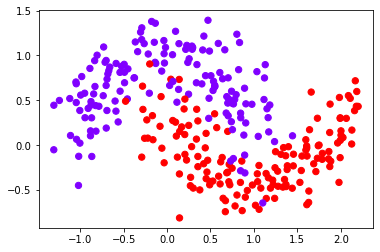

In [29]:
np.random.seed(3)
train_X, train_Y = sklearn.datasets.make_moons(n_samples = 300, noise =.2)

# Visualize the data
plt.scatter(train_X[:, 0], train_X[:, 1], c = train_Y, s = 40, cmap = plt.cm.rainbow);
train_X = train_X.T
train_Y = train_Y.reshape((1, train_Y.shape[0]))

In [30]:
print("Shape of train X :", train_X.shape)
print("Shape of train y :", train_Y.shape)

Shape of train X : (2, 300)
Shape of train y : (1, 300)


In [31]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    
    # 3-layer neural network
    
    L = len(layers_dims)            
    costs = []                      
    t = 0     # counter                  
    seed = 10                    
    m = X.shape[1]          
    
    # Initialize parameters
    parameters = init_params(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass   # no initialization required
    elif optimizer == "adam":
        v, s = init_adam(parameters)
    
    for i in range(num_epochs):
        
        seed = seed + 1 # reshuffle differently the dataset after each epoch
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            # Forward prop
            a3, caches = forward_prop(minibatch_X, parameters)
            logprobs = np.multiply(-np.log(a3),minibatch_Y) + np.multiply(-np.log(1 - a3), 1 - minibatch_Y)
            cost_total += np.sum(logprobs)

            # Backward prop
            grads = backward_prop(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_params_gd(parameters, grads, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # counter
                parameters, v, s = update_params_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

- mini-batch Gradient descent

In [32]:
def predict(X, y, parameters):

    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    a3, caches = forward_prop(X, parameters)
    
    # prediction (0,1)
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p, a3

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367
Cost after epoch 5000: 0.551977
Cost after epoch 6000: 0.532370
Cost after epoch 7000: 0.514007
Cost after epoch 8000: 0.496472
Cost after epoch 9000: 0.468014


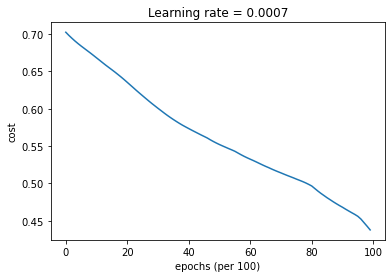

Accuracy: 0.7966666666666666
Wall time: 12.6 s


In [36]:
%%time
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

predictions_gd, prob_gd = predict(train_X, train_Y, parameters)

- ADAM

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066
Cost after epoch 5000: 0.134240
Cost after epoch 6000: 0.131127
Cost after epoch 7000: 0.130216
Cost after epoch 8000: 0.129623
Cost after epoch 9000: 0.129118


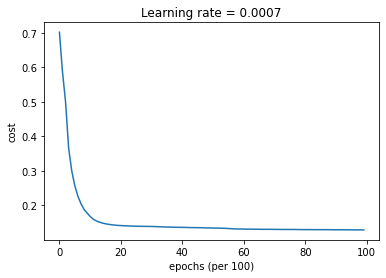

Accuracy: 0.94
Wall time: 16.3 s


In [37]:
%%time
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions_gd, prob_adam = predict(train_X, train_Y, parameters)

### References
[1] Deep Learning Specialization on Coursera, https://www.coursera.org/specializations/deep-learning  
[2] Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).